<a href="https://colab.research.google.com/github/hajaulee/HaJaULS/blob/master/correcting_rotation_of_documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls -ial '/content/drive/My Drive/correcting-rotation-of-documents/test_dataset'

total 1009
44 -rw------- 1 root root  90604 Mar 16 14:56 0-the-cu-chi.jpg
42 -rw------- 1 root root 116900 Mar 16 14:56 0-viet-tay.jpg
41 -rw------- 1 root root  45636 Mar 16 14:45 0-vi.jpg
46 -rw------- 1 root root 113079 Mar 16 15:21 180-japan.jpg
47 -rw------- 1 root root 104953 Mar 16 15:34 180-the-cu-chi.jpg
48 -rw------- 1 root root 114676 Mar 16 15:35 180-viet-tay.jpg
49 -rw------- 1 root root 105561 Mar 16 15:35 270-the-cu-chi.jpg
50 -rw------- 1 root root 117317 Mar 16 15:35 270-viet-tay.jpg
43 -rw------- 1 root root 106081 Mar 16 14:56 90-the-cu-chi.jpg
45 -rw------- 1 root root 115443 Mar 16 15:18 90-viet-tay.jpg


In [4]:
import cv2 as cv
import glob
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import Convolution2D, Dropout, Dense, Flatten, MaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import metrics, regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
working_path = '/content/drive/My Drive/correcting-rotation-of-documents'
image_shape = (200,200,1)
nb_classes = 4

In [0]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [0]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [0]:
def load_data(folder):
    X, labels, names = [],[], []
    list_images_file = glob.glob(os.path.join(folder, "*.jpg"))
    for filename in list_images_file:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, image_shape[:2])
        img = np.asarray(img)
        img = img.reshape(image_shape)
        label = os.path.basename(filename)[0]
        X.append(img)
        labels.append(label)
        names.append(os.path.basename(filename))
#         print ('Loaded', filename)
    print("Loaded", len(list_images_file), 'files')
    return np.asarray(X), np.asarray(labels), names

In [0]:
def get_model(nb_classes):
    # size of pooling area for max pooling
    pool_size = (2, 2)
    # convolution kernel size
    kernel_size = (3,3)
    # convolution strides
    strides = (1,1)

    # model definition
    input = Input(shape=image_shape)
    x = Convolution2D(96, kernel_size,strides=(2,2),
                      activation='relu')(input)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(69, kernel_size, strides=strides,
                      activation='relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(64, kernel_size, strides=strides,
                      activation='relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.45)(x)
    x = Flatten()(x)
    x = Dense(169, activation='relu')(x)
    x = Dropout(rate=0.39)(x)
    x = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=[input], outputs=x)

    model.summary()
    # model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [0]:
def train(model, train_, test_):
    # training parameters
    batch_size = 128
    nb_epoch = 50

    output_filename = 'model.json'
    # callbacks
    checkpointer = ModelCheckpoint(
        filepath=output_filename,
        save_best_only=True
    )
    early_stopping = EarlyStopping(patience=2)
    tensorboard = TensorBoard()


    # training loop
    with tf.device('/gpu:0'):
        histories = model.fit(train_[0], train_[1],
            epochs=nb_epoch,
            batch_size=125,
            validation_data=test_,
            verbose=True,
            shuffle=True,
            callbacks=[checkpointer, early_stopping, tensorboard]
        )

    return model, histories

In [17]:
start_time = time.time()
# Build model
model = get_model(nb_classes)
build_model_time = time.time() - start_time
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 198, 198, 96)      960       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 96)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 99, 99, 96)        384       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 69)        59685     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 69)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 69)        276       
__________

In [12]:
start_time = time.time()
images_path = os.path.join(working_path,'train_dataset')
print('Load images from', images_path)
X_data, Y_data, N_data = load_data(images_path)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=.2, random_state=42)

load_data_time = time.time() - start_time
print('Training with', len(X_train), 'images and validate with', len(X_test), 'images') 

Load images from /content/drive/My Drive/correcting-rotation-of-documents/train_dataset
Loaded 2156 files
Training with 1724 images and validate with 432 images


In [0]:
labelencoder_X = LabelEncoder()
Y_train = labelencoder_X.fit_transform(Y_train)
Y_test = labelencoder_X.transform(Y_test)

Y_train = indices_to_one_hot(Y_train, nb_classes)
Y_test = indices_to_one_hot(Y_test, nb_classes)

In [18]:
start_time = time.time()
model, history = train(model, train_=(X_train, Y_train), test_=(X_test, Y_test))
train_model_time = time.time() - start_time
print("Training complete")

Train on 1724 samples, validate on 432 samples
Epoch 1/50
1724/1724 [==============================] - 11s 6ms/step - loss: 1.0821 - acc: 0.6868 - val_loss: 0.4120 - val_acc: 0.8611
Epoch 2/50
1724/1724 [==============================] - 10s 6ms/step - loss: 0.2774 - acc: 0.9107 - val_loss: 0.3742 - val_acc: 0.8912
Epoch 3/50
1724/1724 [==============================] - 10s 6ms/step - loss: 0.2181 - acc: 0.9385 - val_loss: 1.0050 - val_acc: 0.7338
Epoch 4/50
1724/1724 [==============================] - 10s 6ms/step - loss: 0.1434 - acc: 0.9606 - val_loss: 0.2347 - val_acc: 0.9329
Epoch 5/50
1724/1724 [==============================] - 10s 6ms/step - loss: 0.1103 - acc: 0.9669 - val_loss: 0.2661 - val_acc: 0.9190
Epoch 6/50
1724/1724 [==============================] - 10s 6ms/step - loss: 0.0864 - acc: 0.9751 - val_loss: 0.2075 - val_acc: 0.9514
Epoch 7/50
1724/1724 [==============================] - 10s 6ms/step - loss: 0.0831 - acc: 0.9687 - val_loss: 0.4886 - val_acc: 0.8380
Epoch 8/

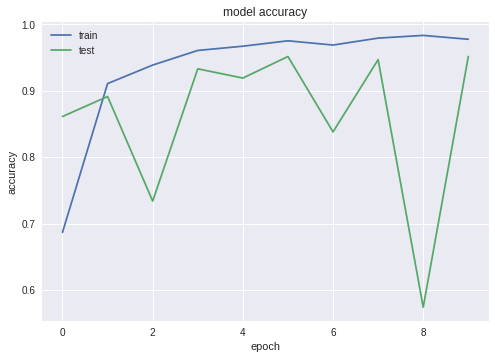

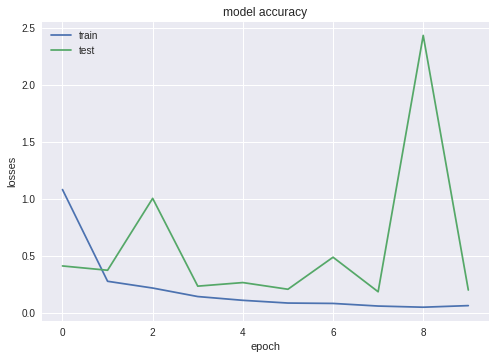

432/432 [==============================] - 1s 2ms/step
Evaluate model: loss:0.20084957088585254, acc:0.9513888888888888
Build model in 0.510673999786377 seconds.
Load data in 639.347371339798 seconds.
Train model in 104.21261954307556 second.


In [19]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Evaluate model: loss:{}, acc:{}".format(test_loss, test_acc))
print("Build model in {} seconds.".format(build_model_time))
print("Load data in {} seconds.".format(load_data_time))
print("Train model in {} second.".format(train_model_time))

In [20]:
print("Label:",Y_test[1])
tmp_test = np.expand_dims(X_test[1], axis=0)
print("Predict:",model.predict(tmp_test))

real_data = load_data(os.path.join(working_path,'test_dataset'))

real_labels = indices_to_one_hot(labelencoder_X.transform(real_data[1]), nb_classes)

print(np.expand_dims(np.asarray(real_data[2]), axis=1))
print("Real data label:\n", real_labels)
predicted_result = model.predict(real_data[0])
hot_results = []

for row in predicted_result:
    hot_index = np.where(row == max(row))[0][0]
    hot_result = [0] * len(row)
    hot_result[hot_index] = 1
    hot_results.append(hot_result)
hot_results = np.asarray(hot_results)
print("Real data Predict:\n", hot_results)

real_test_loss, real_test_acc = model.evaluate(real_data[0], real_labels)
print("Evaluate model: loss:{}, acc:{}".format(real_test_loss, real_test_acc))

Label: [1. 0. 0. 0.]
Predict: [[9.9830151e-01 1.2627676e-03 4.1989435e-04 1.5743777e-05]]
Loaded 10 files
[['0-vi.jpg']
 ['0-viet-tay.jpg']
 ['90-the-cu-chi.jpg']
 ['0-the-cu-chi.jpg']
 ['90-viet-tay.jpg']
 ['180-japan.jpg']
 ['180-the-cu-chi.jpg']
 ['180-viet-tay.jpg']
 ['270-the-cu-chi.jpg']
 ['270-viet-tay.jpg']]
Real data label:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Real data Predict:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]]
10/10 [==============================] - 0s 3ms/step
Evaluate model: loss:1.5484278202056885, acc:0.4000000059604645
